In [1]:
!pip install earthengine-api

### Necessary Imports

In [2]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
%matplotlib inline
# ee.Authenticate()


### Initializing the Google Earth Engine API

In [3]:
ee.Initialize()

In [26]:
lc = ee.ImageCollection('MODIS/006/MCD12Q1')

# Import the MODIS land surface temperature collection.
lst = ee.ImageCollection('MODIS/006/MOD11A1')

# Import the USGS ground elevation image.
elv = ee.Image('USGS/SRTMGL1_003')


In [27]:
# Initial date of interest (inclusive).
i_date = '2020-01-01'

# Final date of interest (exclusive).
f_date = '2022-01-01'
# Selection of appropriate bands and dates for LST.
lst = lst.select('LST_Day_1km', 'QC_Day').filterDate(i_date, f_date)

In [28]:

# Define the urban location of interest as a point near Washington, USA.

u_lon = 120.7401
u_lat = 47.7511
u_poi = ee.Geometry.Point(u_lon, u_lat)



In [29]:
scale = 1000  # scale in meters

# Print the elevation near Washington DC, USA.
elv_urban_point = elv.sample(u_poi, scale).first().get('elevation').getInfo()
print('Ground elevation at urban point:', elv_urban_point, 'm')

# Calculate and print the mean value of the LST collection at the point.
lst_urban_point = lst.mean().sample(u_poi, scale).first().get('LST_Day_1km').getInfo()
print('Average daytime LST at urban point:', round(lst_urban_point*0.02 -273.15, 2), '°C')

# Print the land cover type at the point.
lc_urban_point = lc.first().sample(u_poi, scale).first().get('LC_Type1').getInfo()
print('Land cover value at urban point is:', lc_urban_point)



Ground elevation at urban point: 1047 m
Average daytime LST at urban point: 8.94 °C
Land cover value at urban point is: 9


In [30]:
# Get the data for the pixel intersecting the point in urban area.
lst_u_poi = lst.getRegion(u_poi, scale).getInfo()
# Preview the result.
print(lst_u_poi[:5])

[['id', 'longitude', 'latitude', 'time', 'LST_Day_1km', 'QC_Day'], ['2020_01_01', 120.73806576208429, 47.74994892737317, 1577836800000, None, 2], ['2020_01_02', 120.73806576208429, 47.74994892737317, 1577923200000, None, 2], ['2020_01_03', 120.73806576208429, 47.74994892737317, 1578009600000, None, 2], ['2020_01_04', 120.73806576208429, 47.74994892737317, 1578096000000, None, 2]]


## Method to convert the data to a pandas df and pre-processing

In [31]:
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

In [32]:
lst_df_urban = ee_array_to_df(lst_u_poi,['LST_Day_1km'])

def t_modis_to_celsius(t_modis):
    """Converts MODIS LST units to degrees Celsius."""
    t_celsius =  0.02*t_modis - 273.15
    return t_celsius

# Apply the function to get temperature in celsius.
lst_df_urban['LST_Day_1km'] = lst_df_urban['LST_Day_1km'].apply(t_modis_to_celsius)
    
lst_df_urban.tail()

,time,datetime,LST_Day_1km
706,1638835200000,2021-12-07,-4.39
712,1639353600000,2021-12-13,-12.39
718,1639872000000,2021-12-19,-18.13
720,1640044800000,2021-12-21,-22.11
727,1640649600000,2021-12-28,-15.49


In [17]:
lst_df_urban.to_csv("Output_LST.csv")

## Visualizing the data

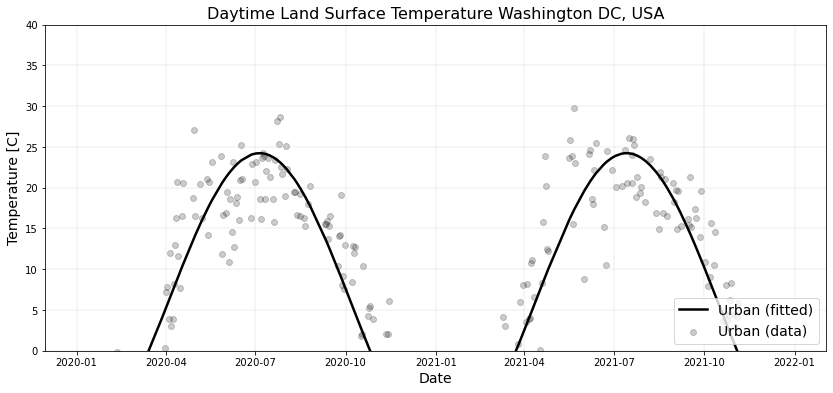

In [35]:
# Fitting curves.
## First, extract x values (times) from the dfs.
x_data_u = np.asanyarray(lst_df_urban['time'].apply(float))  # urban

## Secondly, extract y values (LST) from the dfs.
y_data_u = np.asanyarray(lst_df_urban['LST_Day_1km'].apply(float))  # urban

## Then, define the fitting function with parameters.
def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

## Optimize the parameters using a good start p0.
lst0 = 20
delta_lst = 40
tau = 365*24*3600*1000   # milliseconds in a year
phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0

params_u, params_covariance_u = optimize.curve_fit(
    fit_func, x_data_u, y_data_u, p0=[lst0, delta_lst, tau, phi])

# Subplots.
fig, ax = plt.subplots(figsize=(14, 6))

# Add scatter plots.
ax.scatter(lst_df_urban['datetime'], lst_df_urban['LST_Day_1km'],
           c='black', alpha=0.2, label='Urban (data)')

# Add fitting curves.
ax.plot(lst_df_urban['datetime'],
        fit_func(x_data_u, params_u[0], params_u[1], params_u[2], params_u[3]),
        label='Urban (fitted)', color='black', lw=2.5)


# Add some parameters.
ax.set_title('Daytime Land Surface Temperature Washington DC, USA', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [C]', fontsize=14)
ax.set_ylim(-0, 40)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

plt.show()


In [36]:
# Define a region of interest with a buffer zone of 1000 km around Washington.
roi = u_poi.buffer(1e6)

In [37]:
# Reduce the LST collection by mean.
lst_img = lst.mean()

# Adjust for scale factor.
lst_img = lst_img.select('LST_Day_1km').multiply(0.02)

# Convert Kelvin to Celsius.
lst_img = lst_img.select('LST_Day_1km').add(-273.15)

In [39]:
from IPython.display import Image

# Create a URL to the styled image for a region around France.
url = lst_img.getThumbUrl({
    'min': 10, 'max': 30, 'dimensions': 512, 'region': roi,
    'palette': ['blue', 'yellow', 'orange', 'red']})
print(url)

# Display the thumbnail land surface temperature in France.
print('\nPlease wait while the thumbnail loads, it may take a moment...')
Image(url=url)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/eb4d9cfbc78e916e71cd7d2ff185af14-99abb987cfdeebae23139e5cda536074:getPixels

Please wait while the thumbnail loads, it may take a moment...


## Vsiualizing Ground Elevation in Washington DC

In [40]:
# Make pixels with elevation below sea level transparent.
elv_img = elv.updateMask(elv.gt(0))

# Display the thumbnail of styled elevation in France.
Image(url=elv_img.getThumbURL({
    'min': 0, 'max': 2000, 'dimensions': 512, 'region': roi,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}))